In [153]:
import pandas as pd 
import spacy

In [166]:
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt

In [154]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
%pip install bert-score
from bert_score import BERTScorer

In [156]:
df= pd.read_excel('evaluation.xlsx')

In [157]:
df.head()

,type,test_query,ground_truth,agentic_rag,base_rag,unaugmented,agentic_rag_score,base_rage_score,unaugmented_score
0,Single Topic,What was the Nigerian Barges scheme?,The Nigerian Barges scheme was a fraudulent tr...,The Nigerian Barges scheme was a fraudulent sc...,The Nigerian Barges scheme refers to a fraudul...,The Nigerian Barges scheme was a fraudulent tr...,NaN,NaN,NaN
1,Single Topic,How did Enron utilize accounting loopholes to ...,Enron famously used several accounting loophol...,"Enron utilized accounting loopholes, particula...",The user has shared multiple ways in which Enr...,Enron utilized various accounting loopholes an...,NaN,NaN,NaN
2,Single Topic,What was Cuiaba?,Cuiabá was a power plant project that Enron wa...,Cuiaba was a significant component of the Enro...,"Cuiaba, in this context, was a project involvi...",Cuiabá was an entity within Enron that was inv...,NaN,NaN,NaN
3,Single Topic,Explain the purpose of the Special Purpose Ent...,Special Purpose Entities (SPEs) were a critica...,The primary purpose of the Special Purpose Ent...,The purpose of the Special Purpose Entities (S...,Enron created Special Purpose Entities (SPEs) ...,NaN,NaN,NaN
4,Single Topic,What legal actions were taken against Arthur A...,"Arthur Andersen, the accounting firm that was ...",Legal actions were taken against Arthur Anders...,"After the Enron scandal broke out, Arthur Ande...","Arthur Andersen, one of the ""Big Five"" account...",NaN,NaN,NaN


In [158]:
scorer = BERTScorer(model_type='microsoft/deberta-xlarge-mnli')

In [159]:
#get all candidates into a list
candidate1=df['agentic_rag'].values.tolist()
candidate2=df['base_rag'].values.tolist()
candidate3=df['unaugmented'].values.tolist()
candidates= [candidate1, candidate2, candidate3]

#this is the list of 'ground truths'
references=df['ground_truth'].values.tolist()

In [160]:
#Get the Precision, Recall, F1 Score from the Bert Scorer for all 3 candidates.
P_1, R_1, F1_1 = scorer.score(candidate1, references)
print ('Candidate 1 done')
P_2, R_2, F1_2 = scorer.score(candidate2, references)
print ('Candidate 2 done')
P_3, R_3, F1_3 = scorer.score(candidate3, references)
print ('Candidate 3 done')


Candidate 1 done
Candidate 2 done
Candidate 3 done


In [161]:
#Function to extract all proper nouns like names, dates, locations, etc from the candidates.
def extract_and_count_entities(text):    
    doc = nlp(text)
    
    phrases = []
    
    # Iterate through named entities
    for ent in doc.ents:
        # Filter based on entity label and exclude "Enron"
        if (
            ent.text.lower() != "enron" and
            ent.label_ in {"PERSON", "GPE", "LOC", "DATE", "TIME", "MONEY", "QUANTITY"}
        ):
            phrases.append(ent.text)
    
    # Iterate through proper nouns to capture additional proper noun phrases
    current_phrase = []
    for token in doc:
        if token.text.lower() == "enron":
            continue
        if token.pos_ == "PROPN":  
            current_phrase.append(token.text)
        elif current_phrase:  
            phrases.append(" ".join(current_phrase))
            current_phrase = []
    if current_phrase:  
        phrases.append(" ".join(current_phrase))
    
    # Remove duplicates and return results
    unique_phrases = list(set(phrases)) 
    return len(unique_phrases), unique_phrases
    
    

In [ ]:
#extract the entities for all candidates
final_arr=[]
for i,row in df.iterrows():
    print (i)
    unique_entities_reference, _= extract_and_count_entities(row['ground_truth'])
    unique_entities_candidate1, __ = extract_and_count_entities(row['agentic_rag'])
    unique_entities_candidate2, ___ = extract_and_count_entities(row['base_rag'])
    unique_entities_candidate3, _____ = extract_and_count_entities(row['unaugmented'])
    final_arr.append([row['type'], row['test_query'], row['ground_truth'], unique_entities_reference, row['agentic_rag'],P_1[i].item(), R_1[i].item(), F1_1[i].item() ,unique_entities_candidate1, row['base_rag'], P_2[i].item(), R_2[i].item(), F1_2[i].item(), unique_entities_candidate2,row['unaugmented'], P_3[i].item(), R_3[i].item(), F1_3[i].item(), unique_entities_candidate3])


In [163]:
#final dataframe with pecisions, recalls, f1 scores and entity counts
df_final  = pd.DataFrame(final_arr, columns=['Type', 'Test Query', 'Ground Truth', 'Unique Entities-Ground Truth','Agentic Rag', 'P_1', 'R_1', 'F1_1', 'Unique Entities 1','Base Rag', 'P_2', 'R_2', 'F1_2','Unique Entities 2', 'Unaugmented', 'P_3', 'R_3', 'F1_3', 'Unique Entities 3'])

In [164]:
display(df_final)

,Type,Test Query,Ground Truth,Unique Entities-Ground Truth,Agentic Rag,P_1,R_1,F1_1,Unique Entities 1,Base Rag,P_2,R_2,F1_2,Unique Entities 2,Unaugmented,P_3,R_3,F1_3,Unique Entities 3
0,Single Topic,What was the Nigerian Barges scheme?,The Nigerian Barges scheme was a fraudulent tr...,13,The Nigerian Barges scheme was a fraudulent sc...,0.697405,0.605698,0.648324,5,The Nigerian Barges scheme refers to a fraudul...,0.695165,0.629826,0.660885,6,The Nigerian Barges scheme was a fraudulent tr...,0.740522,0.620021,0.674935,7
1,Single Topic,How did Enron utilize accounting loopholes to ...,Enron famously used several accounting loophol...,11,"Enron utilized accounting loopholes, particula...",0.697558,0.593289,0.641212,2,The user has shared multiple ways in which Enr...,0.672026,0.607196,0.637968,2,Enron utilized various accounting loopholes an...,0.737010,0.654985,0.693581,1
2,Single Topic,What was Cuiaba?,Cuiabá was a power plant project that Enron wa...,4,Cuiaba was a significant component of the Enro...,0.580226,0.631702,0.604871,9,"Cuiaba, in this context, was a project involvi...",0.620328,0.639817,0.629922,7,Cuiabá was an entity within Enron that was inv...,0.701714,0.684420,0.692959,3
3,Single Topic,Explain the purpose of the Special Purpose Ent...,Special Purpose Entities (SPEs) were a critica...,22,The primary purpose of the Special Purpose Ent...,0.732154,0.596046,0.657126,3,The purpose of the Special Purpose Entities (S...,0.704412,0.606041,0.651534,3,Enron created Special Purpose Entities (SPEs) ...,0.738356,0.669747,0.702380,4
4,Single Topic,What legal actions were taken against Arthur A...,"Arthur Andersen, the accounting firm that was ...",21,Legal actions were taken against Arthur Anders...,0.632439,0.549735,0.588194,6,"After the Enron scandal broke out, Arthur Ande...",0.734692,0.685712,0.709357,15,"Arthur Andersen, one of the ""Big Five"" account...",0.755338,0.627070,0.685253,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,Compound,List the accusations against Arthur Andersen r...,"Arthur Andersen, once one of the ""Big Five"" ac...",11,Arthur Andersen faced several accusations rega...,0.649072,0.641384,0.645205,7,The accusations against Arthur Andersen in rel...,0.669366,0.677938,0.673625,13,Arthur Andersen was the accounting firm respon...,0.756683,0.741919,0.749228,2
96,Compound,In which year were most schemes to defraud und...,The peak period for Enron's fraudulent activit...,17,The year that saw most schemes to defraud at E...,0.714054,0.622909,0.665375,4,The scheme to defraud at Enron reached its pea...,0.701035,0.664804,0.682439,9,"The Enron scandal came to light in 2001, when ...",0.717709,0.704078,0.710828,8
97,Compound,How did Enron's relationship with financial an...,Enron's relationship with financial analysts p...,10,Enron's close ties with financial analysts sig...,0.680259,0.585288,0.629210,2,Enron's relationship with financial analysts p...,0.677214,0.618396,0.646470,2,Enron had a close relationship with financial ...,0.709918,0.644345,0.675544,0
98,Compound,List the primary whistleblowers who contribute...,The primary whistleblower credited with uncove...,13,The primary whistleblowers who uncovering the ...,0.697359,0.598192,0.643980,14,Primary whistleblowers who contributed to unco...,0.699845,0.655886,0.677153,12,The primary whistleblowers who contributed to ...,0.710475,0.593942,0.647003,7


How does the precision, recall and F1 score of the candidates differ from the ground truth?

In [172]:
print ('MEANS OF SCORES')
print ('Precision')
print (df_final['P_1'].mean())
print (df_final['P_2'].mean())
print (df_final['P_3'].mean())
print ('---')
print ('Recall')
print (df_final['R_1'].mean())
print (df_final['R_2'].mean())
print (df_final['R_3'].mean())
print ('---')
print ('F1 Score')
print (df_final['F1_1'].mean())
print (df_final['F1_2'].mean())
print (df_final['F1_3'].mean())


MEANS OF SCORES
Precision
0.6602048444747924
0.682605944275856
0.7308689326047897
---
Recall
0.5934393420815468
0.6233161950111389
0.6727469575405121
---
F1 Score
0.6236857998371125
0.6507614502310752
0.7001668679714202


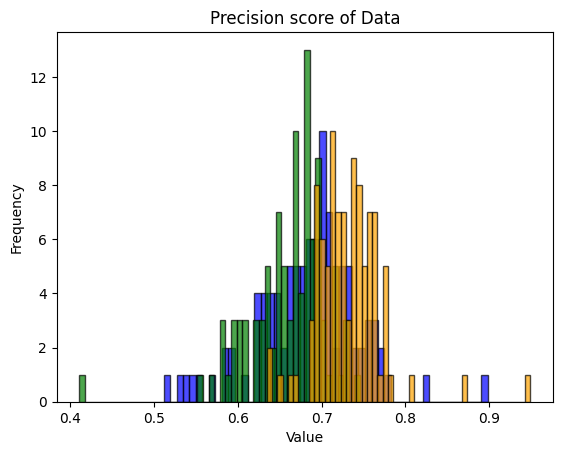

In [167]:
#Precision Score 

plt.hist(df_final['P_2'], bins=50 ,color='blue', alpha=0.7, edgecolor='black')
plt.hist(df_final['P_1'], bins=50, color='green', alpha=0.7, edgecolor='black')
plt.hist(df_final['P_3'], bins=50, color='orange', alpha=0.7, edgecolor='black')
plt.title("Precision score of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

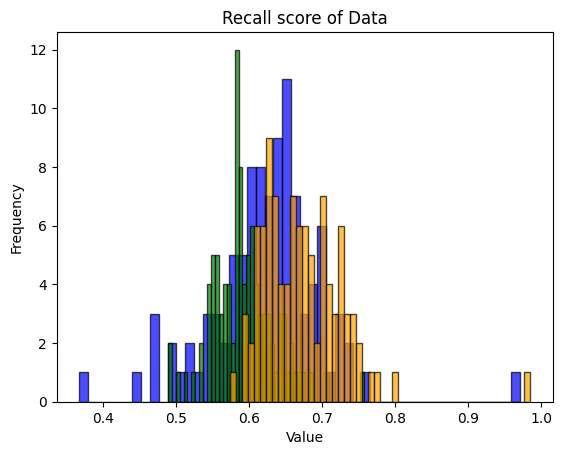

In [168]:
#Recall Score

plt.hist(df_final['R_2'], bins=50 ,color='blue', alpha=0.7, edgecolor='black')
plt.hist(df_final['R_1'], bins=50, color='green', alpha=0.7, edgecolor='black')
plt.hist(df_final['R_3'], bins=50, color='orange', alpha=0.7, edgecolor='black')
plt.title("Recall score of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

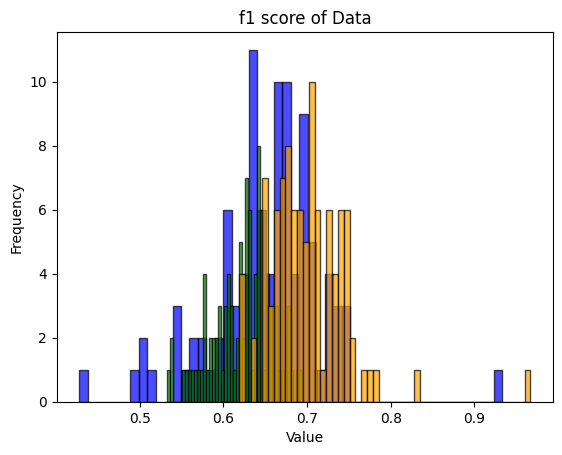

In [169]:
#F1 Score

plt.hist(df_final['F1_2'], bins=50 ,color='blue', alpha=0.7, edgecolor='black')
plt.hist(df_final['F1_1'], bins=50, color='green', alpha=0.7, edgecolor='black')
plt.hist(df_final['F1_3'], bins=50, color='orange', alpha=0.7, edgecolor='black')
plt.title("f1 score of Data")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

There is a visible difference in the scores of the 3 candidates. 

Let us now analyze if this difference is statistically significant. Since we want to evaluate the performance of the Agentic RAG specifically, we will perform a t test between the Agentic RAG scores versus the other scores.

In [170]:

print('PRECISION')
print ('Agentic RAG vs Base RAG')
stat, p_value = ttest_rel(P_1, P_2)
print (stat, p_value)
print ('Agentic RAG vs Unaugmented RAG')
stat, p_value = ttest_rel(P_1, P_3)
print (stat, p_value)
print ('---')
print ('RECALL')
print ('Agentic RAG vs Base RAG')
stat, p_value = ttest_rel(R_1, R_2)
print (stat, p_value)
print ('Agentic RAG vs Unaugmented RAG')
stat, p_value = ttest_rel(R_1, R_3)
print (stat, p_value)
print ('---')
print ('F1 Score')
print ('Agentic RAG vs Base RAG')
stat, p_value = ttest_rel(F1_1, F1_2)
print (stat, p_value)
print ('Agentic RAG vs Unaugmented RAG')
stat, p_value = ttest_rel(F1_1, F1_3)
print (stat, p_value)
print ('---')

PRECISION
Agentic RAG vs Base RAG
-3.0073451073777515 0.0033408651862639016
Agentic RAG vs Unaugmented RAG
-10.795360327950593 2.0290998720699134e-18
---
RECALL
Agentic RAG vs Base RAG
-4.327258079924914 3.612357601534184e-05
Agentic RAG vs Unaugmented RAG
-15.47109400227616 3.6011751332246105e-28
---
F1 Score
Agentic RAG vs Base RAG
-3.89613085202098 0.000177774277221152
Agentic RAG vs Unaugmented RAG
-13.7575504568921 1.0375716779833278e-24
---


There is a statistically significant difference in F1, Precision, and Recall between the Agentic RAG and both the Base RAG and Unaugmented responses. Specifically, the Unaugmented system had the highest performance, followed by Base RAG, with Agentic RAG consistently showing the lowest scores across all metrics. The F1 scores show that Unaugmented Response is significantly better than both Agentic and Base RAG, which aligns with the individual precision and recall findings.

Does the entity score differ?

In [173]:
#Calculate the ratio of the entities in the candidates versus the entities in the Ground truth
df_final['Unique Entities 1'] =  df_final['Unique Entities 1'] /df_final['Unique Entities-Ground Truth']
df_final['Unique Entities 2'] =  df_final['Unique Entities 2'] /df_final['Unique Entities-Ground Truth']
df_final['Unique Entities 3'] =  df_final['Unique Entities 3'] /df_final['Unique Entities-Ground Truth']

print (df_final['Unique Entities 1'].mean())
print (df_final['Unique Entities 2'].mean())
print (df_final['Unique Entities 3'].mean())




0.7311379025989759
0.5672930786770501
0.5340372854452464


Here, the Agentic RAG performs better than the other candidates.

In [144]:
df_final.to_excel('Evaluation Results.xlsx')